# YouTube trending videos

In [27]:
import os

import numpy as np
from numpy import nan

# import sys
# sys.path.append('..')

from typing import List

import pandas as pd
from matplotlib import pyplot as plt

from helpers.json_helper import load_tokenized_text
from helpers.files import load_csv, load_csv_file

from scipy import stats

numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day", "publish_time", "movie_domains_count"
]


## Etap 5 - Zbieranie danych nie-trending

### Skrypt do zbierania danych trending

Pierwszym krokiem, który został wykonany w ramach tego etapu było
zapoznanie się z oryginalnym skryptem do pobierania danych „trending".
Skrypt jest dostępny w repozytorium [Trending-Youtube-Scraper](https://github.com/mitchelljy/Trending-YouTube-Scraper).

Oryginalny skrypt do pobierania danych pobierał filmy z sekcji trending dla danego
dnia, którym był dzień uruchomienia skryptu. Kilka atrybutów np. *trending date*, było
tworzone w ramach skryptu na podstawie danych pobranych z api.
W celu ujednolicenia sposobu tworzenia atrybutów zostało to uwzględnione podczas
pisania skryptu do pobrania danych nie trending.


### Pomysł na pobranie danych nie trending

Podczas wysyłania żądań do interfejsu api serwisu YouTube zostały przyjęte
następujące założenia:
- Pobieranie filmów dla dwóch krajów osobno GB i US (parametr *region_code*).
- Filtrowanie danych po kategoriach, w zbiorze znajdują się tylko
kategorie występujące w oryginalnym zbiorze danych.
- Podczas pobierania danych starano się zachować oryginalne dysproporcje między
kategoriami, z jakich pochodziły filmy.
- 11.2017-07.2018 - okres, w którym film musiał zostać opublikowany,
wybrany na podstawie danych trending.
- Dodatkowo w wyżej wymieniony zakres czasu został podzielony na
4 podokresy, w celu bardziej jednorodnego rozłożenia czasów publikacji.
- Kolejnym ważnym aspektem było sprawdzanie, czy dany film nie pojawił się
w zbiorze danych, do filtrowania służył atrybut *video_id*.
- Do zbioru danych nie zostały dopuszczane duplikaty.

Po etapie wyszukiwania filmów w zbiorze danych zostały uzupełnione brakujące
atrybuty część z nich jak statystyki dotyczące wyświetleń, polubień, komentarzy
wymagały wygenerowania kolejnych żądań. Pozostałe przetwarzanie, np. tokenizacja
atrybutów tekstowych, przygotowanie atrybutów czasowych zostały dokonane lokalnie.

### Wczytanie danych trending

In [2]:
gb_videos, us_videos = load_csv("ped3_data")
trending_videos = pd.concat([gb_videos, us_videos])

for name in numeric_attrs:
    trending_videos[name] = trending_videos[name].apply(lambda x: eval(x)[-1] if eval(x) else np.nan)
trending_videos["tags"] = trending_videos["tags"].apply(lambda x: eval(x)[-1] if eval(x) else np.nan)


### Wczytanie danych nie trending

In [3]:
gb_non_videos, us_non_videos = load_csv("ped5_non_trending")
non_trending_videos = pd.concat([gb_non_videos, us_non_videos])
non_trending_videos.rename(columns={"category_id": "new_category_id"}, inplace=True)

### Atrybuty liczbowe

**Funkcja do rysowania wykresów**

In [107]:
def plot_numeric_attr(attr_name: str, trending: pd.DataFrame, non_trending: pd.DataFrame) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    axes[0, 0].hist(trending[attr_name])
    axes[0, 0].title.set_text(f"Trending: {attr_name}")
    axes[0, 1].hist(non_trending[attr_name])
    axes[0, 1].title.set_text(f"Non Trending: {attr_name}")
    axes[1, 0].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"]
    )
    axes[1, 1].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"],
        showfliers=False
    )

**Views**

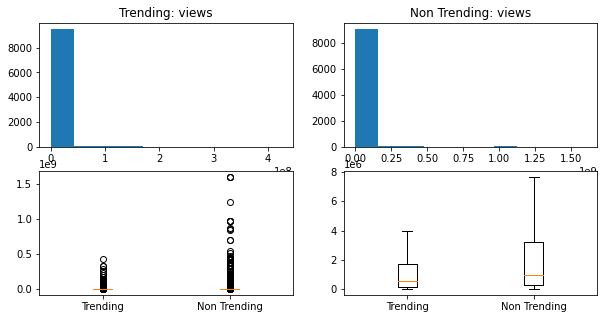

In [108]:
plot_numeric_attr("views", trending_videos, non_trending_videos)

**Likes**

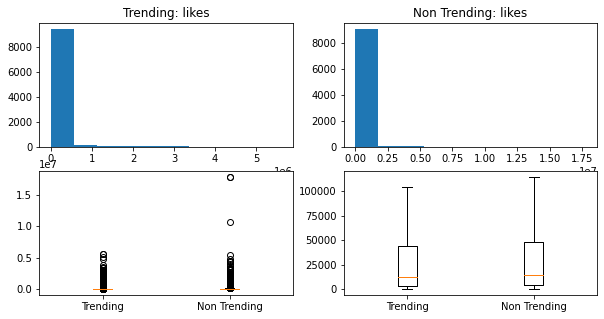

In [109]:
plot_numeric_attr("likes", trending_videos, non_trending_videos)

**Dislikes**

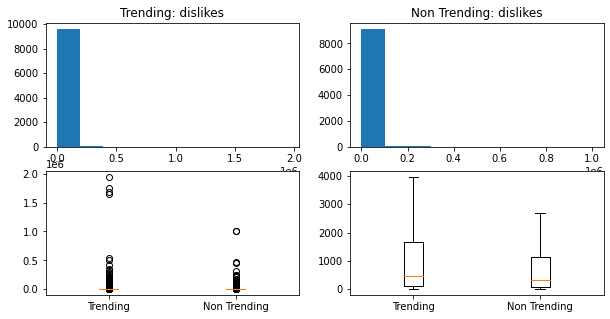

In [110]:
plot_numeric_attr("dislikes", trending_videos, non_trending_videos)

**Comment Count**

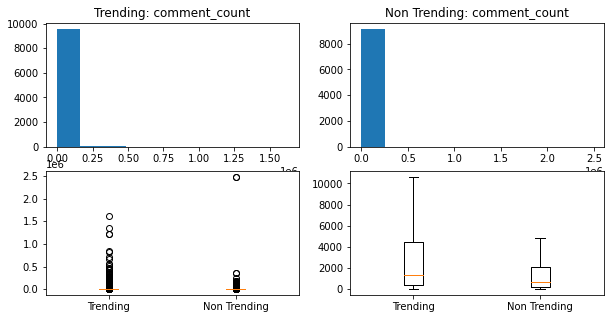

In [111]:
plot_numeric_attr("comment_count", trending_videos, non_trending_videos)

**Description length**

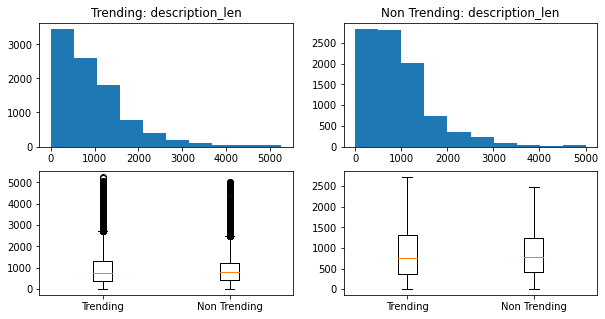

In [112]:
plot_numeric_attr("description_len", trending_videos, non_trending_videos)

**Title length**

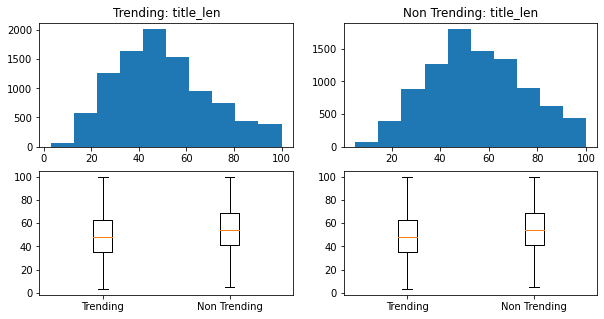

In [113]:
plot_numeric_attr("title_len", trending_videos, non_trending_videos)

**Channel title length**

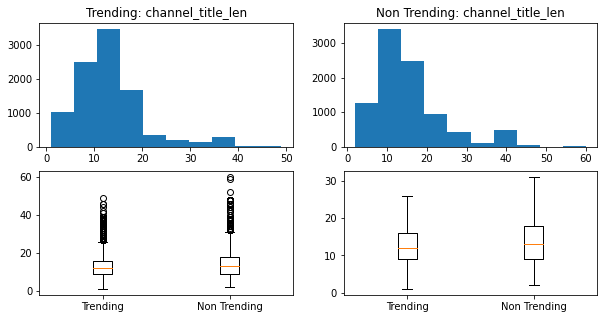

In [114]:
plot_numeric_attr("channel_title_len", trending_videos, non_trending_videos)

**Liczba linków**

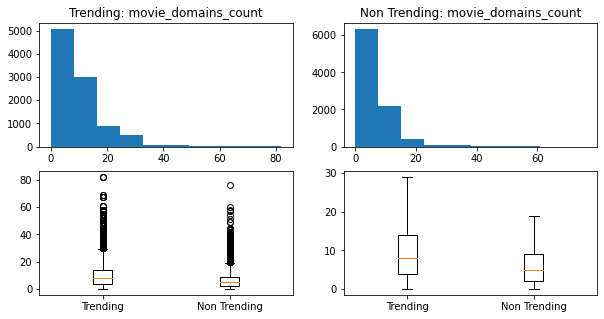

In [115]:
plot_numeric_attr("movie_domains_count", trending_videos, non_trending_videos)

### Atrybuty czasowe

**Dzień opublikowania filmu**

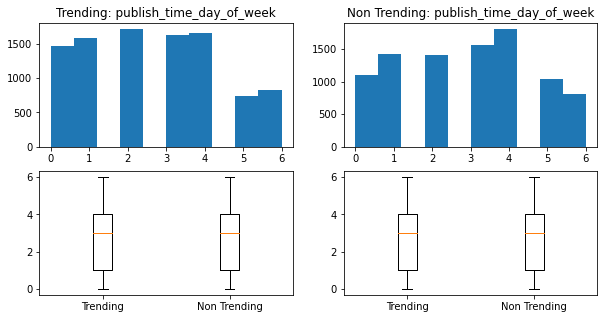

In [116]:
plot_numeric_attr("publish_time_day_of_week", trending_videos, non_trending_videos, )

**Godzina opublikowania filmu**

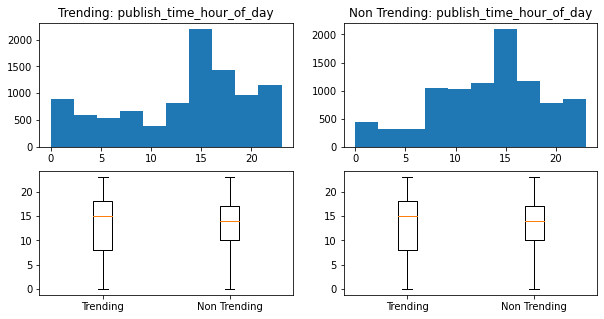

In [117]:
plot_numeric_attr("publish_time_hour_of_day", trending_videos, non_trending_videos)

**Data publikacji**

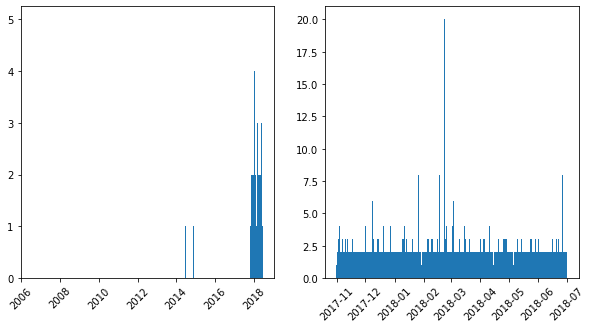

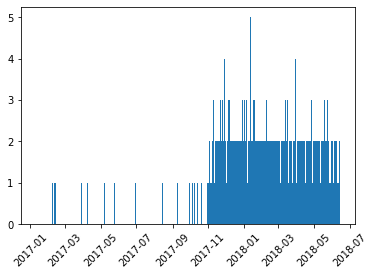

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

trending_publish_time_counts = pd.to_datetime(trending_videos["publish_time"],
                                              format="%Y-%m-%dT%H:%M:%S.%fZ").value_counts()
trending_publish_time_counts = trending_publish_time_counts.rename_axis("publish_time").reset_index(name="count")

publish_times = pd.to_datetime(trending_videos["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ")
filtered = publish_times[publish_times >= "2017-01-01"]
filtered_counts = filtered.value_counts().rename_axis("publish_time").reset_index(name="count")

non_trending_publish_time_counts = pd.to_datetime(non_trending_videos["publish_time"],
                                                  format="%Y-%m-%dT%H:%M:%SZ").value_counts()
non_trending_publish_time_counts = non_trending_publish_time_counts.rename_axis("publish_time").reset_index(
    name="count")

axes[0].bar(pd.to_datetime(trending_publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"),
            trending_publish_time_counts["count"])
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

axes[1].bar(pd.to_datetime(non_trending_publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%SZ"),
            non_trending_publish_time_counts["count"])
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
plt.show()

plt.bar(pd.to_datetime(filtered_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"), filtered_counts["count"])
plt.xticks(rotation=45)
plt.show()

### Atrybuty tekstowe

**Metoda do wyświetlania wykresów**

In [119]:
def plot_tokenized_stats(attr_name):
    us_tokens = load_tokenized_text(f"US_grouped_{attr_name}s")
    gb_tokens = load_tokenized_text(f"GB_grouped_{attr_name}s")
    trending_tokens = []
    trending_words = []
    for i, tokens_list in enumerate(gb_tokens + us_tokens):
        if len(tokens_list) > 0:
            trending_tokens.append(tokens_list[0])
            trending_words += tokens_list[0]
        else:
            trending_tokens.append([])
    trending_words = pd.DataFrame(data={"words": trending_words})
    trending_values_counts = trending_words.value_counts().rename_axis("words").reset_index(name="count")
    tr_head = trending_values_counts.head(50)
    non_trending_path = os.path.join("non_trending", "words")

    gb_non_words = load_csv_file(os.path.join(non_trending_path, f"GB_{attr_name}.csv"))
    us_non_words = load_csv_file(os.path.join(non_trending_path, f"US_{attr_name}.csv"))
    non_trending_words = pd.concat([gb_non_words, us_non_words])
    non_trending_values_counts = non_trending_words.value_counts().rename_axis("words").reset_index(name="count")
    non_tr_head = non_trending_values_counts.head(50)

    plt.subplots(figsize=(18, 5))
    plt.bar(tr_head["words"], tr_head["count"])
    plt.title("Trending")
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

    plt.subplots(figsize=(18, 5))
    plt.bar(non_tr_head["words"], non_tr_head["count"])
    plt.title("Non Trending")
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

**Tytuły kanałów - channel_title**

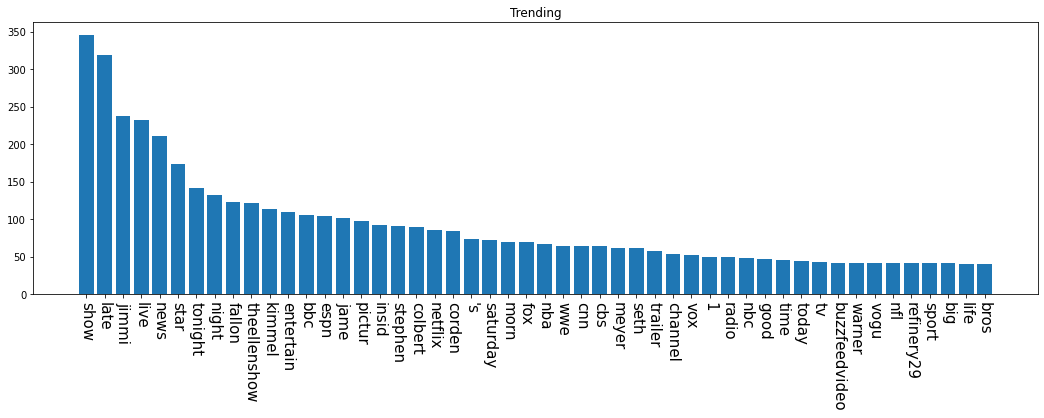

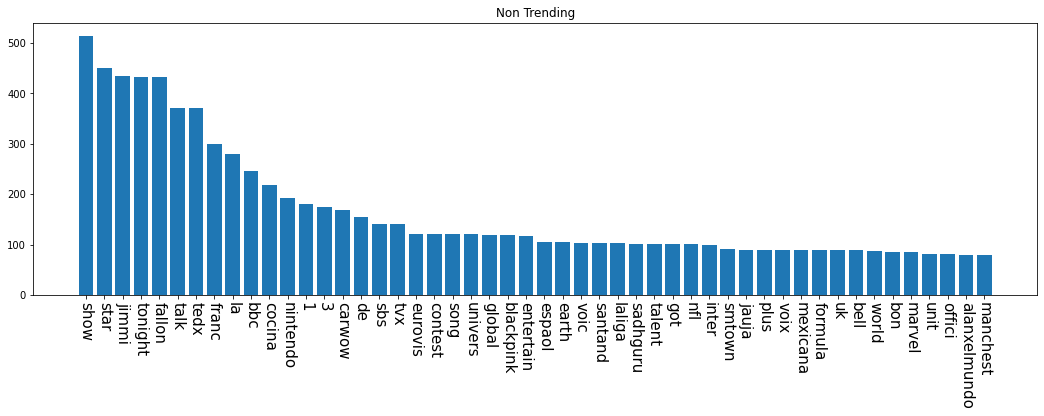

In [120]:
plot_tokenized_stats("channel_title")

**Tytuły filmów - title**

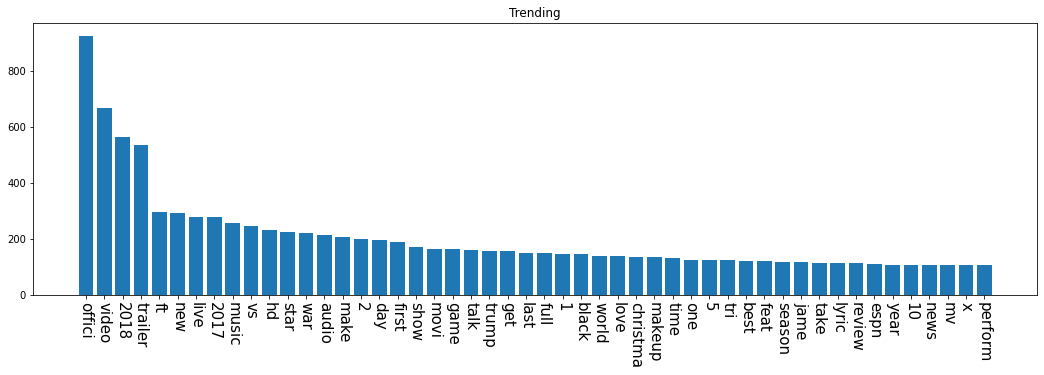

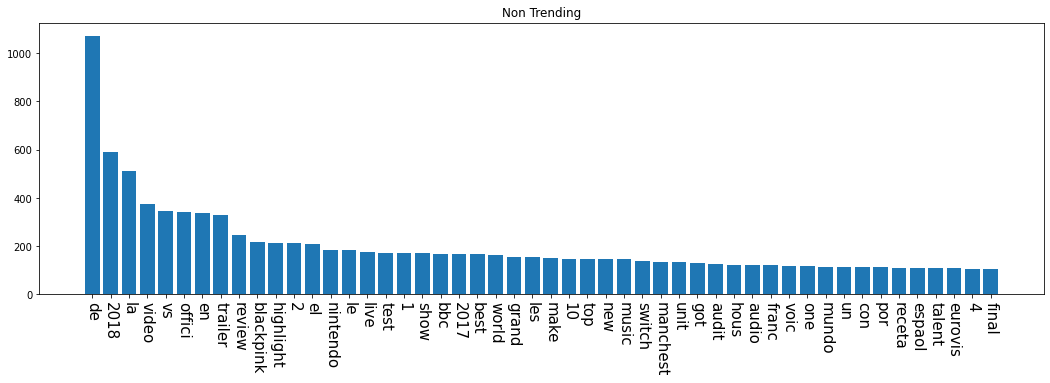

In [121]:
plot_tokenized_stats("title")

**Opisy filmów - description**

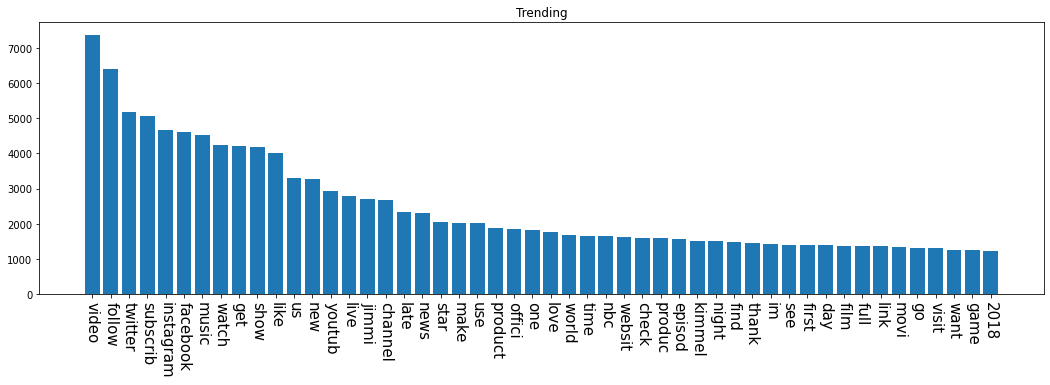

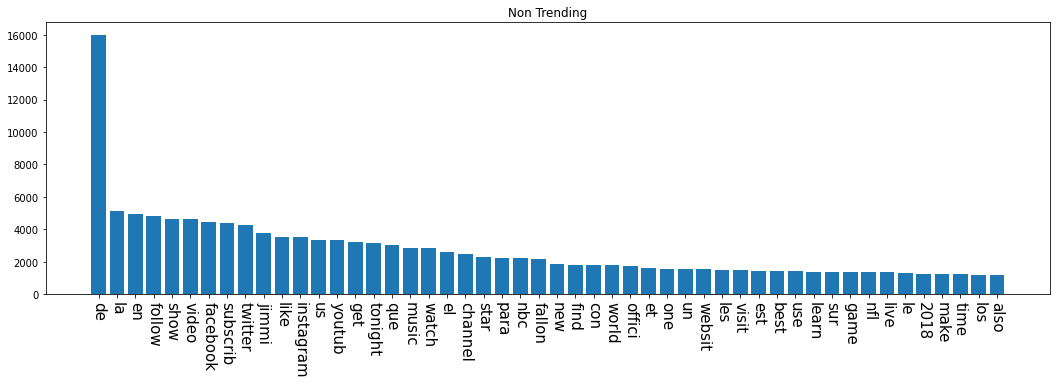

In [122]:
plot_tokenized_stats("description")

**Domeny**

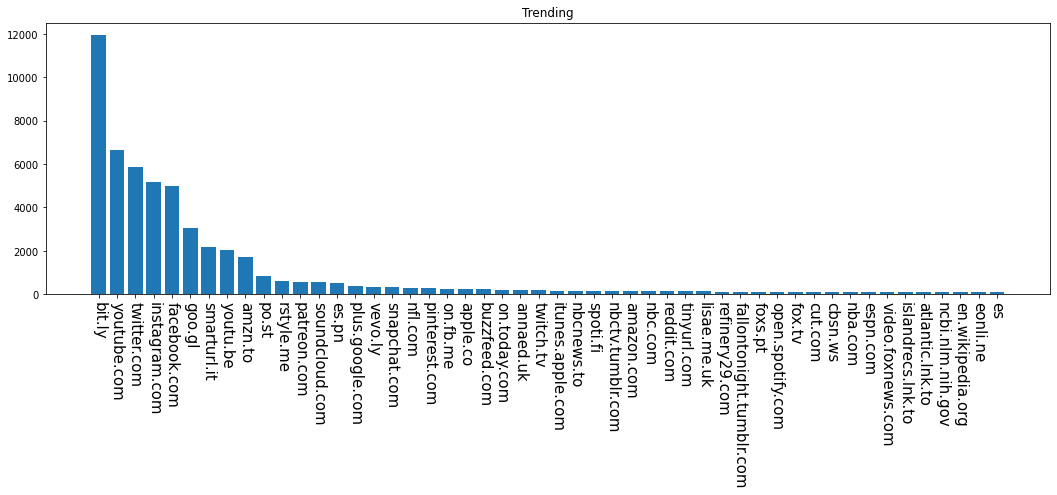

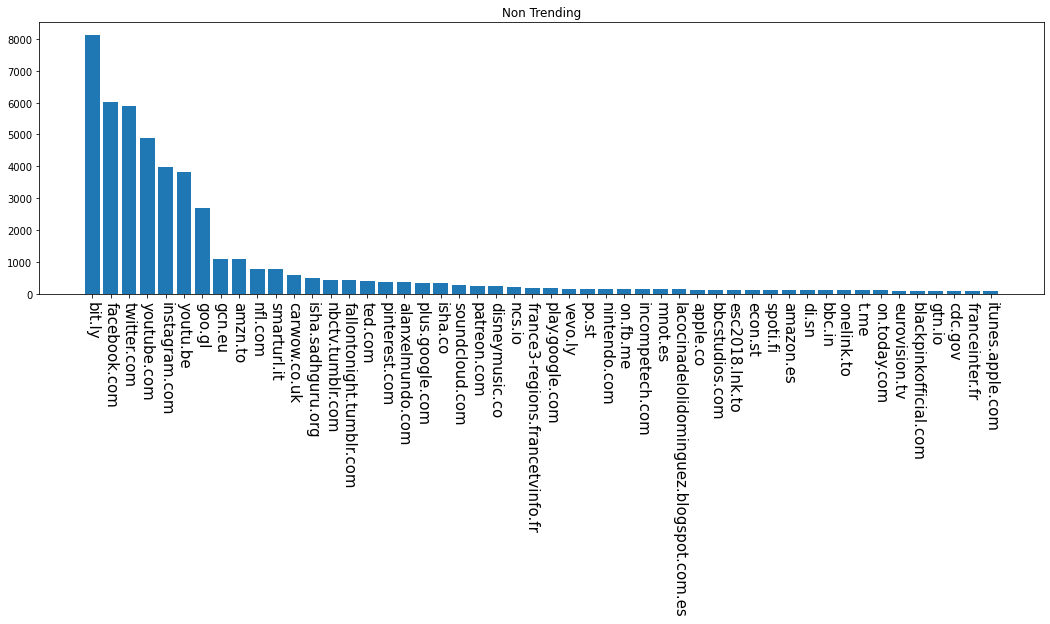

In [123]:
plot_tokenized_stats("domain")

**Tagi**

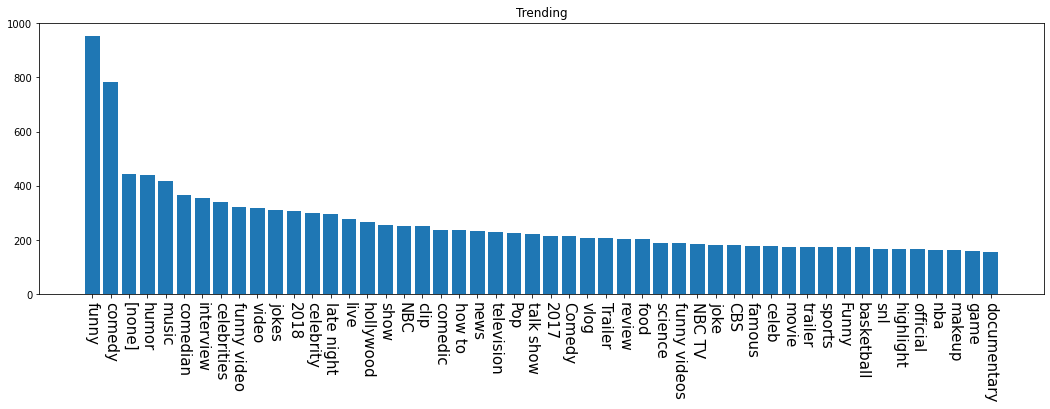

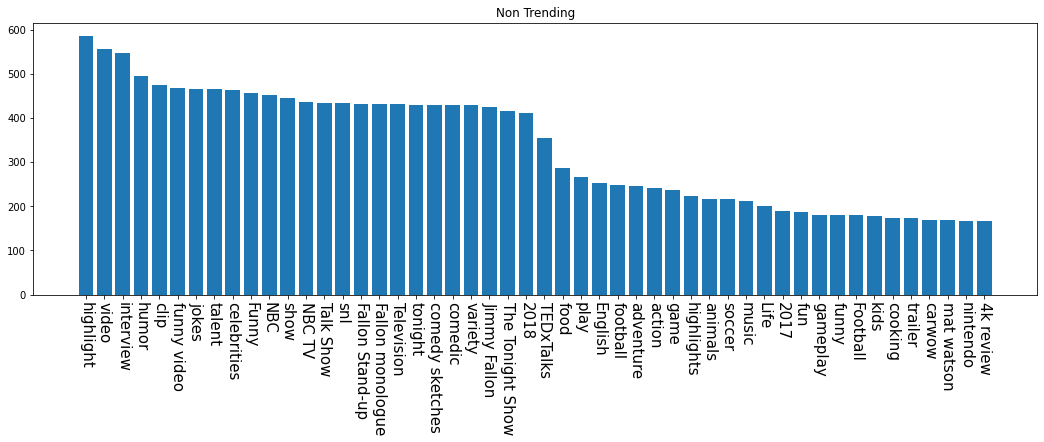

In [124]:
def prepare_tags(tags):
    tags.index = tags.index.droplevel(-1)
    tags.name = "tags"
    tags = tags.to_frame()
    tags_counts = tags.value_counts()
    tags_counts = tags_counts.rename_axis("tag").reset_index(name="count")
    return tags_counts


non_trending_tags = non_trending_videos["tags"].str.split("|").apply(pd.Series, 1).stack()
trending_tags = trending_videos["tags"].str.split("|").apply(pd.Series, 1).stack()

non_trending_tags = prepare_tags(non_trending_tags)
trending_tags = prepare_tags(trending_tags)

plt.subplots(figsize=(18, 5))
plt.bar(trending_tags["tag"].head(50), trending_tags["count"].head(50))
plt.title("Trending")
plt.xticks(rotation=270, fontsize=15)
plt.show()

plt.subplots(figsize=(18, 5))
plt.bar(non_trending_tags["tag"].head(50), non_trending_tags["count"].head(50))
plt.title("Non Trending")
plt.xticks(rotation=270, fontsize=15)
plt.show()

### Podsumowanie wykresów

Podczas analizy danych trending vs non trending, został zauważony pewien problem,
ponieważ dane pochodziły z konkretnych dni z lat 2017-2018, jednak pobierane statystyki
dla danych non trending pochodzą z roku 2021. To tłumaczyłoby anomalie takie jak np. wyższe
liczby wyświetleń w filmach non trending. W celu wyeliminowania tego problemu
przeprowadzona została także analiza z nowo pobranymi statystykami filmów trending.

### Wczytanie odświeżonych danych trending

In [125]:
gb_videos, us_videos = load_csv("ped5_trending")
trending_videos = pd.concat([gb_videos, us_videos])
trending_videos.rename(columns={"category_id": "new_category_id"}, inplace=True)

**Views**

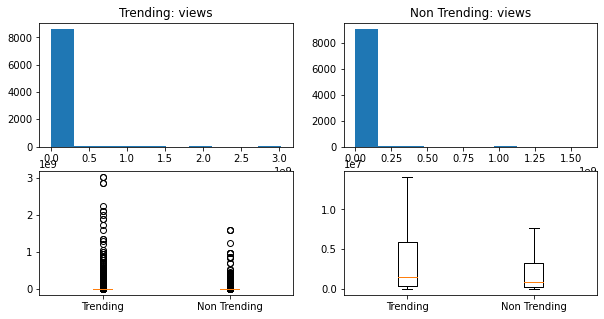

In [126]:
plot_numeric_attr("views", trending_videos, non_trending_videos)

**Likes**

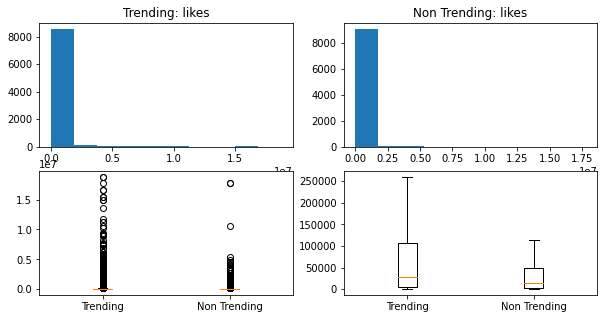

In [127]:
plot_numeric_attr("likes", trending_videos, non_trending_videos)

**Dislikes**

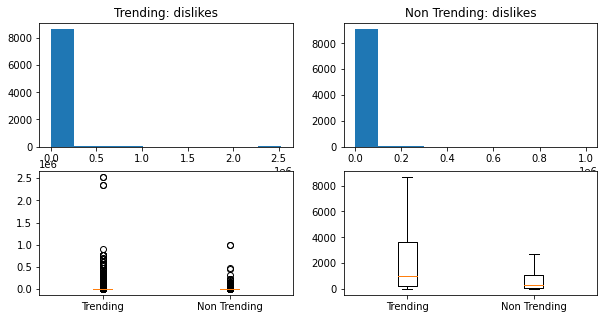

In [128]:
plot_numeric_attr("dislikes", trending_videos, non_trending_videos)

**Comment Count**

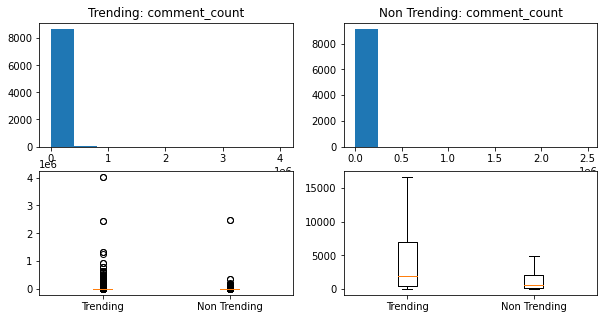

In [129]:
plot_numeric_attr("comment_count", trending_videos, non_trending_videos)

**Description length**

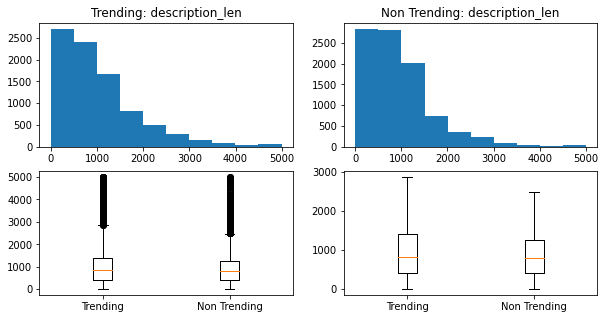

In [130]:
plot_numeric_attr("description_len", trending_videos, non_trending_videos)

**Title length**

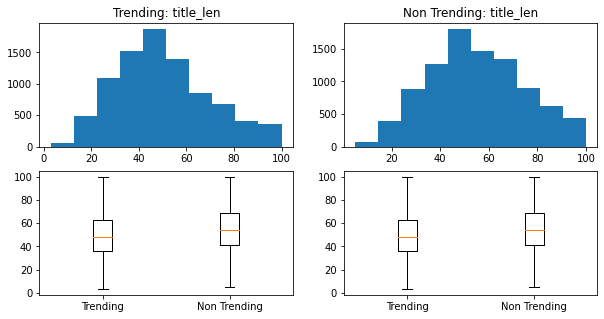

In [131]:
plot_numeric_attr("title_len", trending_videos, non_trending_videos)

**Channel title length**

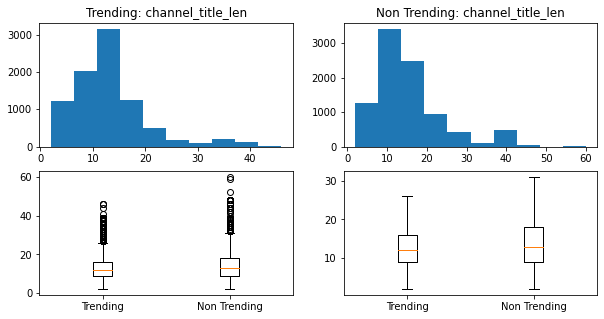

In [132]:
plot_numeric_attr("channel_title_len", trending_videos, non_trending_videos)

**Liczba linków**

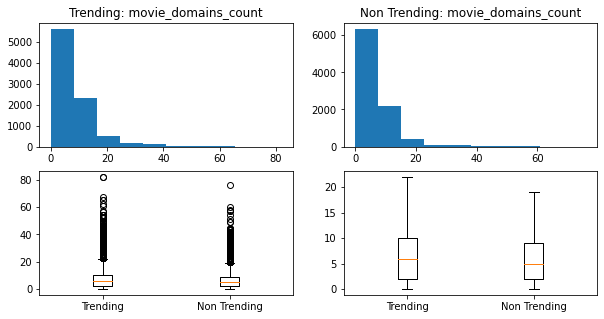

In [133]:
plot_numeric_attr("movie_domains_count", trending_videos, non_trending_videos)

## Ocena atrybutów


### Atrybuty numeryczne

Korelacja atrybutów liczbowych z kategorią

Atrybuty numeryczne zostały ocenione za pomocą analizy wariancji (ANOVA Analysis of Variance).
Zastosowana metoda wynika z tego, że mamy jednym z atrybutów jest atrybut
nominalny - *category_id*.

Przyjęte hipotezy:

$$ H_0 $$: Średnie w poszczególnych kategoriach są takie same.

$$ H_1 $$: Średnie w poszczególnych kategoriach są różne.


Przyjęty poziom istotności: $$ \alpha = 0.05 $$

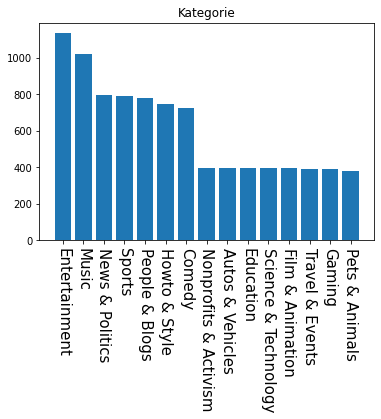

Kategorie Liczba wartości 'nan':0


In [24]:
from helpers.categories import get_categories_dict
from helpers.files import load_csv, save_csv

numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day"
]

categories_dict = get_categories_dict()

def plot_categories(title: str, categories_dict: dict, data: pd.DataFrame) -> list:
    nan_count = data["new_category_id"].isna().sum()
    plt.title(title)
    attr_c = data["new_category_id"].value_counts()
    attr_c = attr_c.rename_axis("new_category_id").reset_index(name="count")
    labels = [categories_dict[i] for i in attr_c["new_category_id"]]
    plt.bar(labels, attr_c["count"])
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

    print(f"{title} Liczba wartości 'nan':{nan_count}")
    return attr_c["new_category_id"].tolist()

def anova(data: List[pd.DataFrame], attr: str):
    data_set = list(map(lambda x: x[attr].dropna(), data))
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    print(f"{attr}: f_score = {f_score} p_value = {p_value}")
    plt.title(attr)
    plt.boxplot(data_set, showfliers=False)
    labels = [categories_dict[i] for i in categories]
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=270, fontsize=15)
    plt.show()
    return f_score, p_value


categories = plot_categories("Kategorie", categories_dict, non_trending_videos)

views: f_score = 48.05796549132997 p_value = 1.4340532774771592e-129


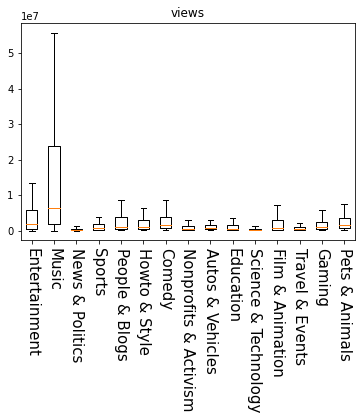

likes: f_score = 45.03148833553995 p_value = 3.866022063545984e-121


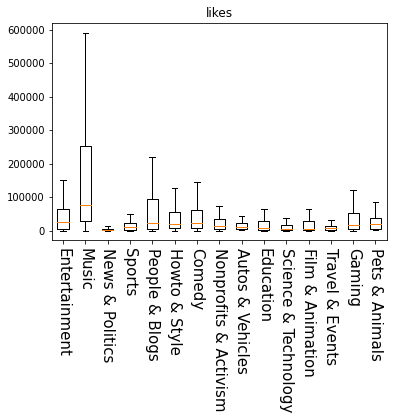

dislikes: f_score = 23.123022494190966 p_value = 1.7617511696478035e-59


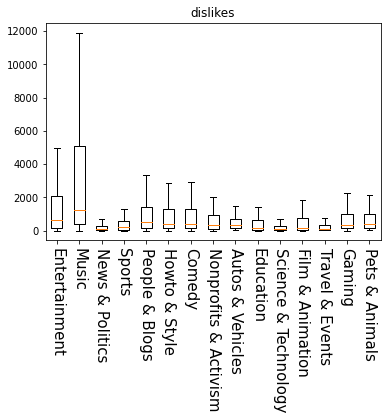

comment_count: f_score = 9.454723287688106 p_value = 3.4312123328641856e-21


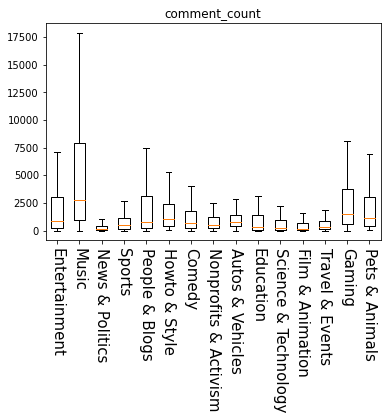

description_len: f_score = 45.5569734664027 p_value = 1.3230394988296587e-122


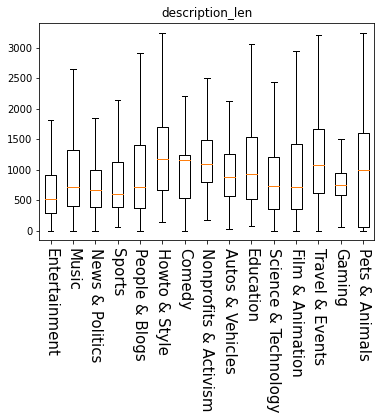

title_len: f_score = 71.85186846287792 p_value = 7.212143778341004e-195


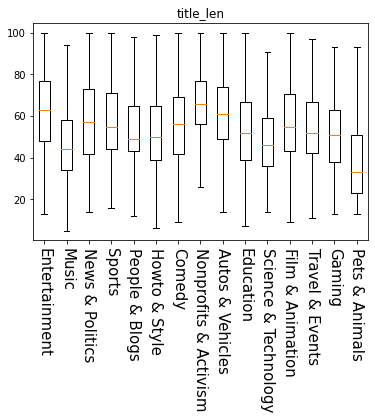

channel_title_len: f_score = 268.76874255187414 p_value = 0.0


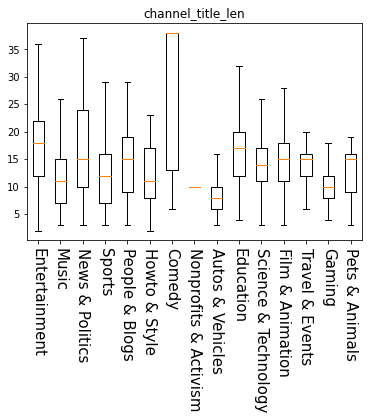

publish_time_day_of_week: f_score = 20.926930716145915 p_value = 2.847742946866234e-53


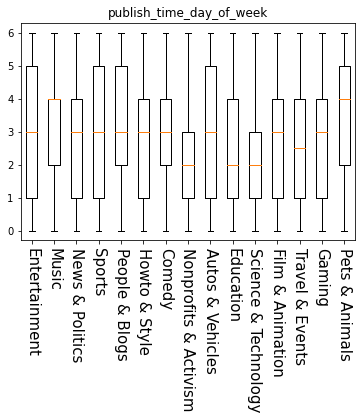

publish_time_hour_of_day: f_score = 63.285092050133386 p_value = 1.4458670367930232e-171


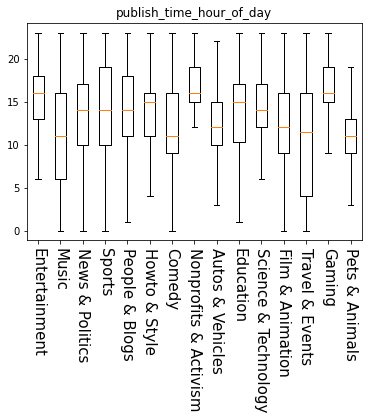

ValueError: could not convert string to float: '2017-11-26T17:00:04Z'

In [28]:
categories_data = []
for category_id in categories:
    c_data = non_trending_videos[non_trending_videos["new_category_id"] == category_id]
    categories_data.append(c_data)

f_scores = pd.DataFrame()
alpha = 0.05
for i in numeric_attrs:
    f, p = anova(categories_data, i)
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [i], "f score": [f], "p value": [p], "leq alpha": [p <= alpha]}
    ), ignore_index=True)
f_scores

### Ocena atrybutów tekstowych

Po podaniu tekstów procesowi tokenizacji zostały wygenerowane dla nich cechy
numeryczne, które wyrażają liczbę występujących częstych tokenów przez liczbę wszyskich
często występujących tokenów dla każdej kategorii na każdym atrybucie.

In [31]:
attr = "channel_titles"
for cat in categories:
    attr_name = f"freq_{attr}_{categories_dict[cat]}"
    anova(categories_data, attr_name)

KeyError: 'freq_channel_titles_Entertainment'

In [9]:
trending_videos.columns

Index(['new_video_id', 'Unnamed: 0.1', 'video_id', 'trending_date', 'title',
       'channel_title', 'category_id', 'publish_time', 'tags', 'views',
       ...
       'freq_tags_Sports', 'freq_tags_Travel & Events', 'freq_tags_Gaming',
       'freq_tags_Education', 'freq_tags_Pets & Animals',
       'freq_tags_Science & Technology', 'freq_tags_Film & Animation',
       'freq_tags_Autos & Vehicles', 'freq_tags_Nonprofits & Activism',
       'freq_tags_Shows'],
      dtype='object', length=164)

In [10]:
non_trending_videos.columns

Index(['video_id', 'title', 'channel_title', 'new_category_id', 'publish_time',
       'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'description_len', 'title_len', 'channel_title_len',
       'publish_time_day_of_week', 'publish_time_hour_of_day',
       'movie_domains_count'],
      dtype='object')

In [18]:
non_trending_videos

,video_id,title,channel_title,new_category_id,publish_time,tags,views,likes,dislikes,comment_count,...,comments_disabled,ratings_disabled,video_error_or_removed,description,description_len,title_len,channel_title_len,publish_time_day_of_week,publish_time_hour_of_day,movie_domains_count
0,Ys9ziXRfEMw,Delusional Owner’s ‘$300k' Art Collection Is A...,Gordon Ramsay,24,2017-11-26T17:00:04Z,Gordon Ramsay|Gordon Ramsay recipe|Gordon Rams...,6094689,74409,1247,6137,...,False,False,False,Just a little off his estimates.\n\n#GordonRam...,497,78,13,6,17,7
1,jO2HEVc5iK4,When Michael Jackson called Zac Efron - The Gr...,BBC,24,2017-12-29T13:00:05Z,BBC|iPlayer|gary oldman|zac efron|michael jack...,1374448,25103,156,677,...,False,False,False,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,611,78,3,4,13,4
2,yZ3GlUDdrqg,Jurassic World: Fallen Kingdom - Trailer Thurs...,Universal Pictures,24,2017-12-05T21:37:25Z,Jurassic World|Fallen Kingdom|Jurassic Park|T-...,13974178,195773,6608,6101,...,False,False,False,It’s been three years since theme park and lux...,627,80,18,1,21,2
3,bHBDXe96wbg,Delivery man Liam Payne sings in an elevator -...,BBC,24,2017-11-03T20:13:18Z,BBC|iPlayer|bbc1|bbc 1|bbc one|liam payne|cher...,4219553,81171,1072,1392,...,False,False,False,Subscribe and 🔔 to OFFICIAL BBC YouTube 👉 http...,656,81,3,4,20,4
4,c1r6rCp8heA,Weird Owner Leaves Threatening Notes All Over ...,Gordon Ramsay,24,2017-11-05T16:30:01Z,Gordon Ramsay|Gordon Ramsay recipe|Gordon Rams...,16753371,196866,3941,11784,...,False,False,False,Even the cookies...\n\n#GordonRamsay #Cooking ...,484,70,13,6,16,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,Xdhmgp4IUL0,Don't Believe Everything You Think | Lauren We...,TEDx Talks,29,2018-06-05T19:55:22Z,TEDxTalks|English|Life|Behavior|Change|Communi...,1660503,30893,824,799,...,False,False,False,Lauren Weinstein delivers an inspiring TEDxPal...,1431,68,10,1,19,2
4516,EZ1ncb_qoA8,Come uscire dalla comfort zone del forse | Fra...,TEDx Talks,29,2018-05-31T18:09:43Z,TEDxTalks|Italian|Life|Choice|Success,644395,23909,642,626,...,False,False,False,Quante volte ci è stato detto no? Quante volte...,1121,92,10,3,18,1
4517,vTpLtNdXDgk,El poder de decir SÍ | Juan Lombana | TEDxUDLAP,TEDx Talks,29,2018-05-21T15:29:37Z,TEDxTalks|Spanish|Business|Digital|Entrepreneu...,49767,2037,34,47,...,False,False,False,"Las oportunidades van y no regresan, por eso J...",1868,47,10,0,15,1
4518,xrWvPo-KaVs,How to 'overcome' fear | Trevor Ragan | TEDxCe...,TEDx Talks,29,2018-06-14T18:45:22Z,TEDxTalks|English|Education|Behavior|Fear|Grit...,167500,4108,79,165,...,False,False,False,Fear can be helpful when we're in danger but s...,1544,55,10,3,18,2
